# Sentiment Analysis

In [1]:

import sys
from os import chdir

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

sys.path.insert(0, '..')

from src import TEST_DATA_PATH, TRAIN_DATA_PATH
from src.preprocessing.DataCleaner import DataCleaner
from src.preprocessing.Stemmer import Stemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kryst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
MAX_FEATURES = 200_000
RANDOM_SEED = 42
SAMPLE_SIZE = 0.1

In [3]:
# change directory to root
chdir('..')

# Data

Dataset used here is described in [data/README.md](data/README.md)

### Load data

In [4]:
# loading data, we will use only review and label columns, and skip description column with index 1
train_data = pd.read_csv(TRAIN_DATA_PATH, names=['label', 'review'], usecols=[0, 2])
test_data = pd.read_csv(TEST_DATA_PATH, names=['label', 'review'], usecols=[0, 2])
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (3000000, 2)
Test data shape: (650000, 2)


In [5]:
# check for missing values in train data
train_data.isnull().sum()

label     0
review    0
dtype: int64

In [6]:
# check for missing values in test data
test_data.isnull().sum()

label     0
review    0
dtype: int64

### Explore the data

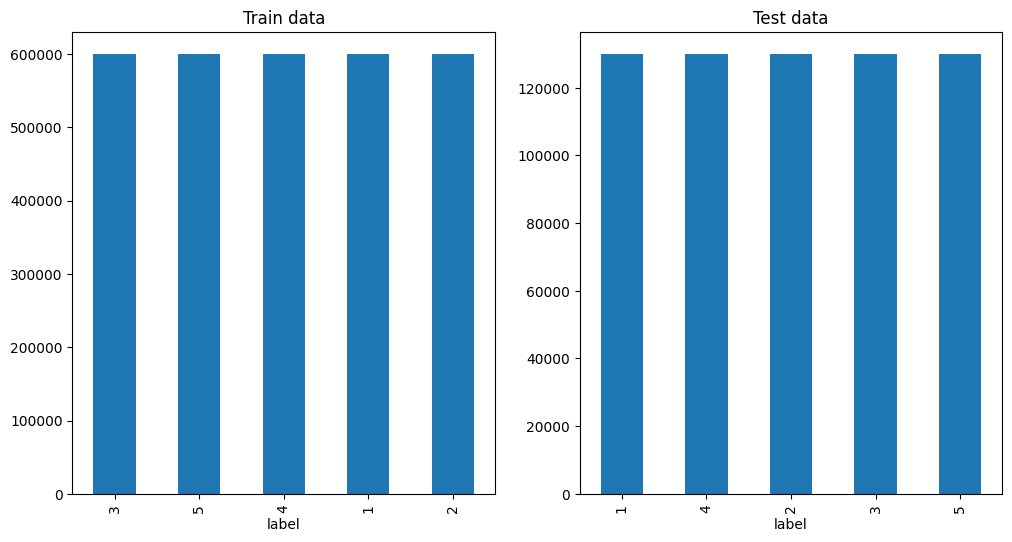

In [7]:
# let's see histogram of the labels in both train and test data
_, ax = plt.subplots(1, 2, figsize=(12, 6))
train_data['label'].value_counts().plot(kind='bar', ax=ax[0], title='Train data')
test_data['label'].value_counts().plot(kind='bar', ax=ax[1], title='Test data')
plt.show()

### Change the labels to positive and negative

According to the data description, <b>1-2 stars are negative</b> and <b>4-5 stars are positive</b>, 3 stars are neutral.
Since we are making a binary classifaication, we can change the labels to <i>negative (0)</i>, <i>positive (1)</i> and drop the neutral reviews.

In [8]:
# drop neutral labels
train_data = train_data[train_data['label'] != 3]
test_data = test_data[test_data['label'] != 3]

# change the labels to 0 for negative and 1 for positive
train_data['label'] = train_data['label'].apply(lambda x: 0 if x < 3 else 1)
test_data['label'] = test_data['label'].apply(lambda x: 0 if x < 3 else 1)

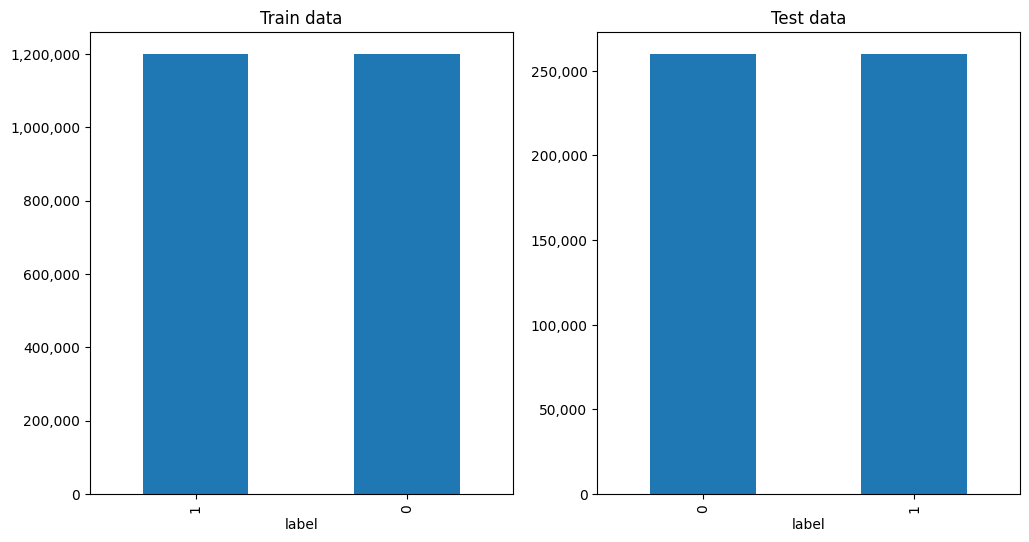

In [9]:
# confirm the changes
_, ax = plt.subplots(1, 2, figsize=(12, 6))

train_data['label'].value_counts().plot(kind='bar', ax=ax[0], title='Train data')
ax[0].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

test_data['label'].value_counts().plot(kind='bar', ax=ax[1], title='Test data')
ax[1].get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

### Closer look at the reviews

In [10]:
train_data.head()

,label,review
1,1,I hope a lot of people hear this cd. We need m...
2,1,I'm reading a lot of reviews saying that this ...
3,1,The music of Yasunori Misuda is without questi...
4,1,Probably the greatest soundtrack in history! U...
5,1,"There's a reason this CD is so expensive, even..."


In [11]:
print(train_data['review'][1])
print("Label:", "positive" if train_data['label'][1] else "negative")

I hope a lot of people hear this cd. We need more strong and positive vibes like this. Great vocals, fresh tunes, cross-cultural happiness. Her blues is from the gut. The pop sounds are catchy and mature.
Label: positive


### Sample the data for further analysis

In [12]:
# sample the data to speed up the experiments
# make sure to stratify the data to keep the same distribution of labels
train_data, _ = train_test_split(train_data, test_size=(1 - SAMPLE_SIZE), stratify=train_data['label'],
                                 random_state=RANDOM_SEED)
test_data, _ = train_test_split(test_data, test_size=(1 - SAMPLE_SIZE), stratify=test_data['label'],
                                random_state=RANDOM_SEED)

# Analyzing the data

### Check the correlation between the review length and the label

In [13]:
all_data = pd.concat([train_data, test_data])
review_length = all_data['review'].apply(len)
data = pd.DataFrame({'review_length': review_length, 'label': all_data['label']})

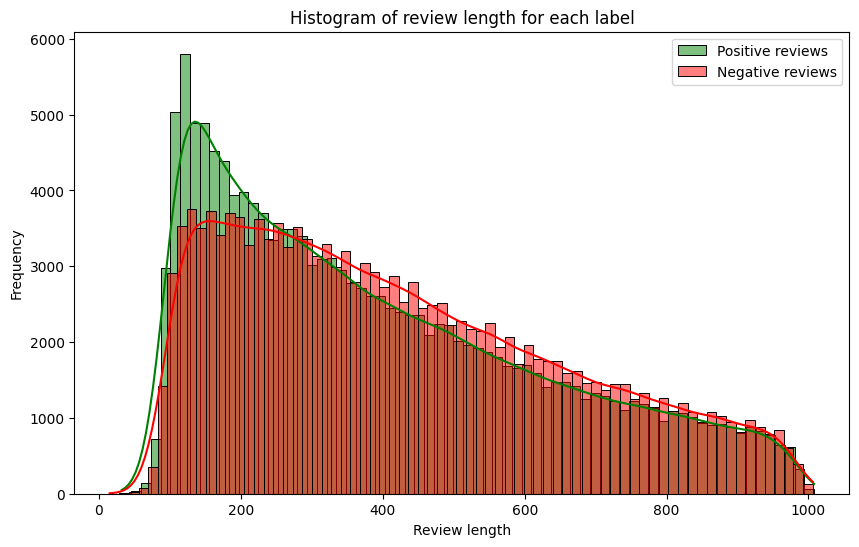

In [14]:
# plot the histogram of review length for each label
plt.figure(figsize=(10, 6))
sns.histplot(data[data['label'] == 1]['review_length'], color='green', kde=True, label='Positive reviews')
sns.histplot(data[data['label'] == 0]['review_length'], color='red', kde=True, label='Negative reviews')
plt.title('Histogram of review length for each label')
plt.xlabel('Review length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
# calculate the correlation between the review length and the label
correlation = data['review_length'].corr(data['label'])
print(f'Correlation between review length and label: {correlation:.4f}')

Correlation between review length and label: -0.0649


The correlation between the review length and the label is very low, which means that the review length is not a good predictor for the label.

# Preprocessing Pipeline

The pipeline will consist of the following steps:

1. Data Cleaning:
    - Convert all words to lowercase.
    - Remove stopwords.
    - Remove punctuation.
    - Remove URLs.
    - Remove handles (e.g., Twitter handles).
    - Remove emojis.
    - Remove extra spaces.

2. Stemming:
    - Reduce words to their root form using a stemming algorithm.

3. Vectorization:
    - Convert text into a matrix of token counts.
    - Set the ngram_range parameter to (1, 2) to include both individual words and pairs of consecutive words.
    - Use a predefined constant MAX_FEATURES to limit the number of most frequent words, discarding less frequent words.

4. TF-IDF Transformation:
    - Transform the matrix of token counts into a normalized TF-IDF representation.
    - This step reduces the importance of frequently occurring words and increases the importance of rarely occurring words, which could be more informative.

We will take closer look how __DataCleaner__ and __Stemmer__ work and how they affect the text.

In [16]:
data_cleaner = DataCleaner()
stemmer = Stemmer()

In [17]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    cleaned_data = data_cleaner.transform(data['review'])
    stemmed_data = stemmer.transform(cleaned_data)
    return pd.DataFrame({
        'review': stemmed_data,
        'label': data['label']
    })

In [18]:
# preprocess the data to make comparison between raw and preprocessed data
train_data_preprocessed = preprocess_data(train_data.copy())
test_data_preprocessed = preprocess_data(test_data.copy())

In [19]:
# compare original and processed review
print("Original review:")
print(train_data['review'].iloc[1])
print("\nPreprocessed review:")
print(train_data_preprocessed['review'].iloc[1])
print("\nLabel:", "positive" if train_data['label'].iloc[1] else "negative")

Original review:
This book left me empty. I've read several of Teresa Meseiros books and count alot of them as some of my favorite romances, not this one. It started out with alot of promise, but the ending was a flop. It was like someone else wrote the third part of the book. The hero Morgan never truely expresses all his true feelings to Sabrina. I love a good romance, but this just wasn't one, sad part is it could have been.

Preprocessed review:
book left empti ve read sever teresa meseiro book count alot favorit romanc one start alot promis end flop like someon els wrote third part book hero morgan never trueli express true feel sabrina love good romanc nt one sad part could

Label: negative


### Most comon words

In [20]:
def calculate_most_common_words(data: pd.DataFrame) -> pd.DataFrame:
    words = data['review'].apply(lambda text: word_tokenize(text.lower())).explode()
    words_count = words.value_counts().reset_index()
    words_count.columns = ['word', 'count']
    return words_count

In [21]:
# calculate the most common words in the raw and preprocessed data
words_raw_data = calculate_most_common_words(all_data)
words_preprocessed_data = calculate_most_common_words(pd.concat([train_data_preprocessed, test_data_preprocessed]))

In [22]:
words_raw_data.head()

,word,count
0,.,1175508
1,the,1137931
2,",",822070
3,i,644081
4,and,610222


In [23]:
words_preprocessed_data.head()

,word,count
0,book,166766
1,number,156085
2,nt,144286
3,one,108743
4,like,93637


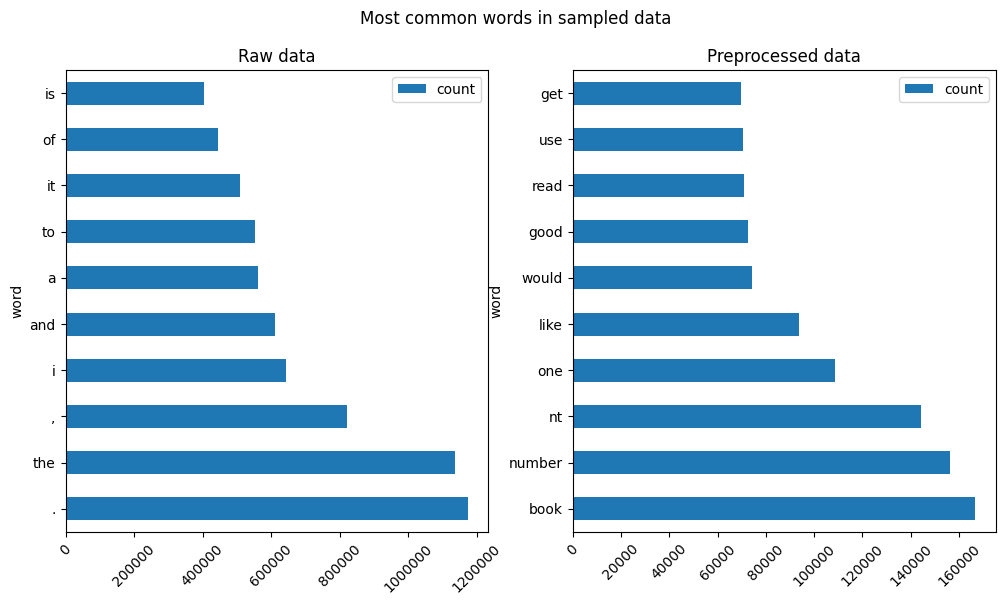

In [24]:
# plot the most common words for processed data and unprocessed data
_, ax = plt.subplots(1, 2, figsize=(12, 6))
words_raw_data.head(10).plot(kind='barh', x='word', y='count', ax=ax[0])
ax[0].set_title('Raw data')
ax[0].tick_params(axis="x", rotation=45)
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

words_preprocessed_data.head(10).plot(kind='barh', x='word', y='count', ax=ax[1])
ax[1].set_title('Preprocessed data')
ax[1].tick_params(axis="x", rotation=45)
ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

plt.suptitle('Most common words in sampled data')
plt.show()

### Words that are most common in the reviews types.

In [25]:
def plot_wordcloud(data, title, ax=None):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(text)

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(16, 6))

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

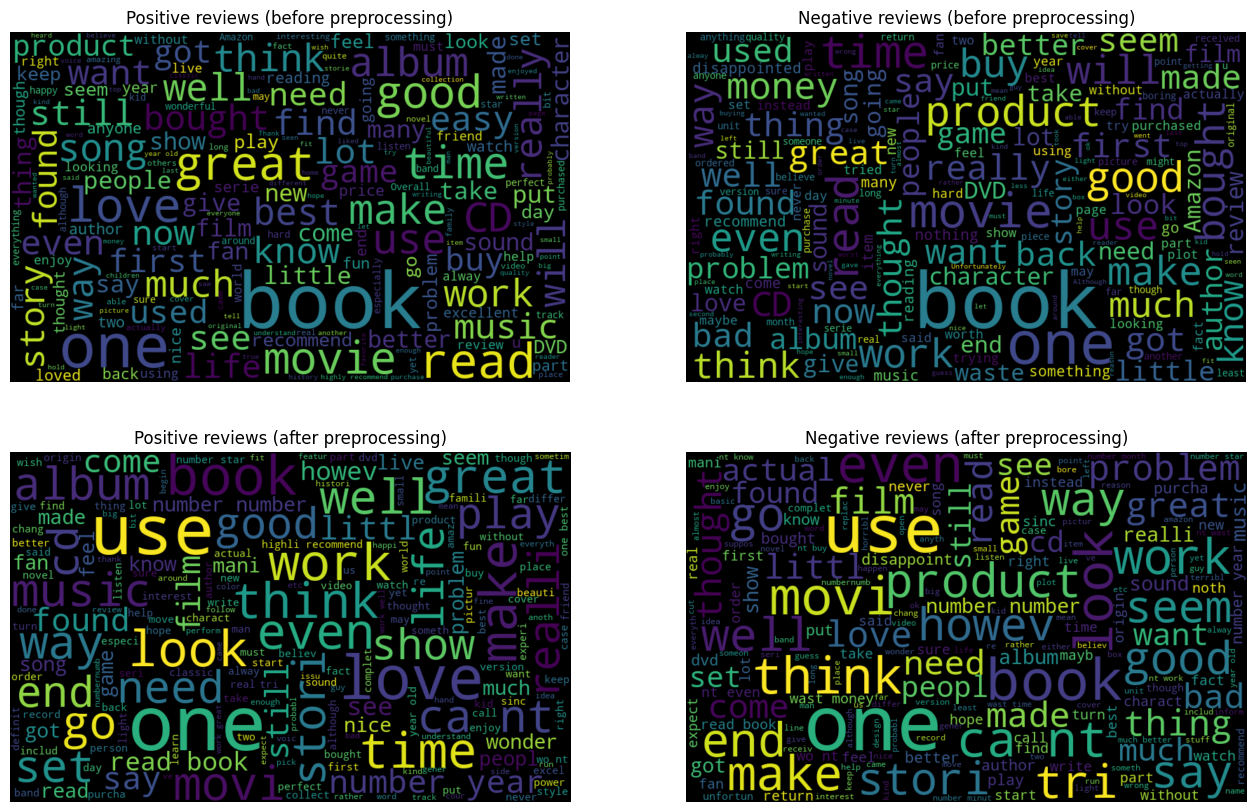

In [26]:
# plot wordclouds for positive and negative reviews in raw and preprocessed data
_, ax = plt.subplots(2, 2, figsize=(16, 10))

plot_wordcloud(train_data[train_data['label'] == 1]['review'], 'Positive reviews (before preprocessing)', ax[0, 0])
plot_wordcloud(train_data[train_data['label'] == 0]['review'], 'Negative reviews (before preprocessing)', ax[0, 1])
plot_wordcloud(train_data_preprocessed[train_data_preprocessed['label'] == 1]['review'],
               'Positive reviews (after preprocessing)', ax[1, 0])
plot_wordcloud(train_data_preprocessed[train_data_preprocessed['label'] == 0]['review'],
               'Negative reviews (after preprocessing)', ax[1, 1])

Preprocessing the data has removed some of the most common words that are not informative, such as "the", "and", "to", etc.